In [1]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500000

In [2]:
data=pd.read_csv('sorted_coded_data.csv')

In [3]:
data=data.sort_values(by=['user_id','start_time','end_time'])

# Calculate sleep time

To calculate the sleep time, we start by determining identifying the app blocks. The app blocks are what are refered to as sequences in the below code.\
The following function is inspried by the following source https://stackoverflow.com/questions/57804145/combining-rows-with-overlapping-time-periods-in-a-pandas-dataframe (visited 29.10.2021). 

In [4]:
def join_times(x):
    startdf = pd.DataFrame({'time':x['start_time'], 'what':1})
    enddf = pd.DataFrame({'time':x['end_time'], 'what':-1})
    mergdf = pd.concat([startdf, enddf]).sort_values(['time','what'])
    mergdf['running'] = mergdf['what'].cumsum()
    mergdf['new_sequence'] = mergdf['running'].eq(1) & mergdf['what'].eq(1)
    mergdf['sequence_number'] = mergdf['new_sequence'].cumsum()
    x['sequence_number'] = mergdf['sequence_number'].loc[mergdf['what'].eq(1)]
    return x['sequence_number']

In [5]:
#determining app blocks
data['sequence_number']=data.groupby('user_id').apply(join_times).reset_index().drop(['user_id','level_1'], axis=1).values
#identify min start time and max end time for each block
data=pd.merge(data,data.groupby(['user_id','sequence_number']).agg({'start_time':'min','end_time':'max'}).reset_index().rename(columns={'end_time':'sequence_end_time','start_time':'sequence_Start_time'}),how='left', on=['user_id','sequence_number'])
#calculate sleep time
data['sleep_time']=data.start_time-data.sequence_end_time.shift(1,fill_value=0)
data.loc[data[data['sleep_time']<0].index,'sleep_time']=0

In [6]:
print("Number of observations: ",data.shape[0])

Number of observations:  254450422


# Sleep time distribution

In [9]:
print("Procent of observation with no (zero) sleep time associated: ",data[data.sleep_time==0].shape[0]/data.shape[0]*100)
print("Longest sleep time: ",data.sleep_time.max()/60/60/24)

Procent of observation with no (zero) sleep time associated:  40.567149462224116
Longest sleep time:  89.44747685185185


Since we can see that the longest sleep time is very long, we start by taking a look at the distribution of sleep time in days.
Here is it is clear that the majority of the sleep times are less than not spanning more than  

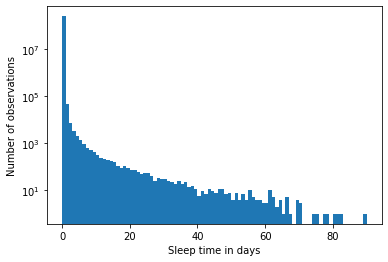

In [11]:
plt.hist(data.sleep_time/60/60/24,bins=range(0, 90 + 1, 1))
plt.xlabel('Sleep time in days')
plt.ylabel('Number of observations')
plt.yscale('log')
#plt.title("Distribution of sleep time")
plt.show()

While the above plot showed that some of the sleep times are more than one day long, such sleep times clear represent time between to unrelated events. We therefore now limit the time period to 8 hours, as this represents a natural limit for the time we sleep every day. The result can be seen below.

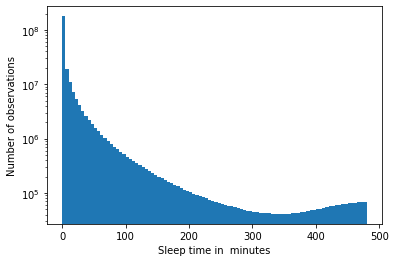

In [10]:
plt.hist(data[data.sleep_time<8*60*60].sleep_time/60,bins=range(0, 480 + 1, 5))
plt.xlabel('Sleep time in  minutes')
plt.ylabel('Number of observations')
plt.yscale('log')
#plt.title("Distribution of sleep time less than 8 hours")
plt.show()

The last version we take a look at the sleep times have been limited to those less than eight hours and above zero. As zero sleep time does not represent an actual sleep time.

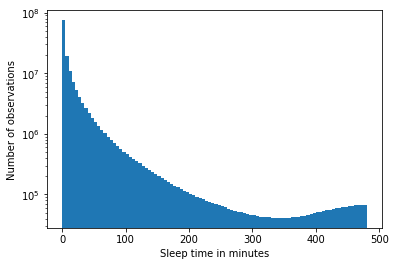

In [12]:
plt.hist(data[(data.sleep_time<8*60*60)&(data.sleep_time>0)].sleep_time/60,bins=range(0, 480 + 1, 5))
plt.xlabel('Sleep time in minutes')
plt.yscale('log')
plt.ylabel('Number of observations')
#plt.title("Distribution of sleep time less than 8 hours")
plt.show()

In [13]:
print("media of sleep times non-zero sleep times less than 8 hours: ",data[(data.sleep_time<8*60*60) & (data.sleep_time>0)].sleep_time.median()/60,"min")

media of sleep times non-zero sleep times less than 8 hours:  4.883333333333334 min


In [14]:
print("median of sleep times less than 8 hours: ",data[data.sleep_time<8*60*60].sleep_time.median(),"sec")

median of sleep times less than 8 hours:  20.0 sec


A sleep time of 20 sec. is close to what we saw for similar projects, and we therefore use this as the threshold for defining sessions.

## Defining sessions

In [15]:
data['new_session'] = data.groupby(['user_id']).sleep_time.apply(lambda s: s>20)
data['session'] = data.groupby(['user_id']).new_session.cumsum().astype('int')

In [16]:
print("Number sessions: ",data.groupby(['user_id']).session.nunique().sum())

Number sessions:  125704179


### Distribution of session lengths

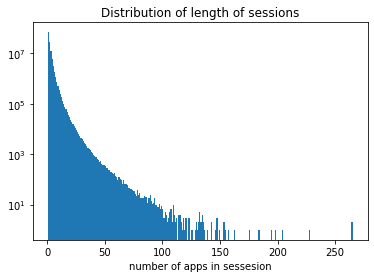

In [17]:
plt.hist(data.groupby(['user_id','session']).size(),bins=range(1,data.groupby(['user_id','session']).size().max()+1,1))
plt.xlabel('number of apps in sessesion')
plt.yscale('log')
plt.title("Distribution of length of sessions")
plt.show()

In [18]:
print("procent of session with only one app: ",(data.groupby(['user_id','session']).size()==1).sum()/data.groupby(['user_id']).session.nunique().sum()*100)

procent of session with only one app:  55.033392326598786


In [19]:
print("75-quantile of session lengths: ",data.groupby(['user_id','session']).size().quantile(q=0.75))

75-quantile of session lengths:  2.0


In [91]:
print("procent of session with only one app: ",(data.groupby(['user_id','session']).size()==1).sum()/data.groupby(['user_id']).session.nunique().sum()*100)

procent of session with only one app:  55.033392326598786


In [92]:
print("75-quantile of session lengths: ",data.groupby(['user_id','session']).size().quantile(q=0.75))

75-quantile of session lengths:  2.0


It is clear to see that with the new time restriction a lot of the sequences are very short. This number is expected to increase further as same apps are merged in the next section

In [20]:
data.to_csv("sorted_coded_session_20s.csv",index=False)

## Combining observations of repeating apps
In this section, we combine observations of the same apps, which are right next to eachother in the usage session.

In [2]:
data=pd.read_csv("sorted_coded_session_20s.csv")

In [3]:
data

,user_id,package_name,start_time,end_time,app_code,time_spend,sequence_number,sequence_Start_time,sequence_end_time,sleep_time,new_session,session
0,0,com.facebook.katana,0,441,19968,441,1,0,441,0,False,0
1,0,com.android.chrome,441,1012,7649,571,2,441,1012,0,False,0
2,0,com.google.android.apps.photos,1012,1032,23916,20,3,1012,1032,0,False,0
3,0,com.facebook.katana,1042,1502,19968,460,4,1042,1502,10,False,0
4,0,com.whatsapp,1512,1572,53003,60,5,1512,1572,10,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
254450417,9999,com.google.android.googlequicksearchbox,29207214,29207244,23949,30,14901,29207214,29207244,185,True,8465
254450418,9999,com.android.chrome,29207244,29207284,7649,40,14902,29207244,29207284,0,False,8465
254450419,9999,com.google.android.apps.docs,29207284,29207294,23875,10,14903,29207284,29207294,0,False,8465
254450420,9999,com.microsoft.office.outlook,29213184,29213213,33357,29,14904,29213184,29213213,5890,True,8466


In [4]:
data["previous_app_code"]=data.groupby(["user_id","session"]).app_code.shift(1)

In [5]:
print("Procent of apps opened right after the same app, in the ",data[data.app_code==data.previous_app_code].shape[0]/data.shape[0]*100)

Procent of apps opened right after the same app, in the  1.507229962463965


In [6]:
data2=data.copy()

In [7]:
data2=data2[(data2.previous_app_code==data2.app_code) | (data2.app_code==data2.groupby(['user_id','session']).app_code.shift(-1))]

In [8]:
data2['new_event'] = data2.previous_app_code!=data2.app_code

In [9]:
data2['event'] = data2.groupby(['user_id','session']).new_event.cumsum().astype('int')

In [10]:
data2_grouped = data2.groupby(['user_id', 'session','event']).agg({'end_time':'max'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'end_time':'event_end_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'session','event'])

data3 = data3[data3['end_time'] == data3['event_end_time']]

#because in the same event more apps can be closed at once.
data3=data3.drop_duplicates(subset=['user_id', 'session','event'], keep='last')

In [11]:
max_index=data2.iloc[data3.index].index

In [12]:
data2_grouped = data2.groupby(['user_id', 'session','event']).agg({'start_time':'min'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'start_time':'event_start_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'session','event'])

data3 = data3[data3['start_time'] == data3['event_start_time']]

#because in the same event more apps can be opened at once.
data3=data3.drop_duplicates(subset=['user_id', 'session','event'], keep='last')

In [13]:
min_index=data2.iloc[data3.index].index

In [14]:
print("number of combined events: ",data2.groupby(['user_id','session']).agg({"event": "nunique"}).event.sum())
print("number of found min indices: ",len(min_index))
print("number of found max indices: ",len(max_index))

number of combined events:  3212632
number of found min indices:  3212632
number of found max indices:  3212632


In [15]:
data3=data.copy()

In [16]:
data3.loc[min_index,"end_time"]=data3.loc[max_index].set_index(min_index).end_time

In [17]:
data3=data3.drop(set(data2.index)-set(min_index))

In [18]:
len(data.index)-(len(data2.index)-len(min_index))==len(data3.index)

True

In [19]:
data3['time_spend']=data3['end_time']-data3['start_time']

In [20]:
data3=data3.drop('previous_app_code',axis=1)

In [21]:
data3['sleep_time']=data3.start_time-data3.sequence_end_time.shift(1,fill_value=0)
data3.loc[data3[data3['sleep_time']<0].index,'sleep_time']=0

In [22]:
data3=data3.reset_index(drop=True)

In [23]:
print("number of observatiosn before merge: ",data.shape[0])
print("number of observatiosn after merge: ",data3.shape[0])

number of observatiosn before merge:  254450422
number of observatiosn after merge:  250615269


In [24]:
data3.to_csv("sorted_coded_session_20s_merged.csv",index=False)

In [24]:
data3=pd.read_csv("sorted_coded_session_20s_merged.csv")

In [25]:
data3[data3.user_id==0]

,user_id,package_name,start_time,end_time,app_code,time_spend,sequence_number,sequence_Start_time,sequence_end_time,sleep_time,new_session,session
0,0,com.facebook.katana,0,441,19968,441,1,0,441,0,False,0
1,0,com.android.chrome,441,1012,7649,571,2,441,1012,0,False,0
2,0,com.google.android.apps.photos,1012,1032,23916,20,3,1012,1032,0,False,0
3,0,com.facebook.katana,1042,1502,19968,460,4,1042,1502,10,False,0
4,0,com.whatsapp,1512,1572,53003,60,5,1512,1572,10,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11218,0,com.jb.zcamera,20208141,20208151,28268,10,10360,20208141,20208151,30514,True,5474
11219,0,com.android.chrome,20208161,20208512,7649,351,10361,20208161,20208512,10,False,5474
11220,0,com.facebook.katana,20208512,20208772,19968,260,10362,20208512,20208772,0,False,5474
11221,0,com.google.android.apps.translate,20208772,20208782,23926,10,10363,20208772,20208782,0,False,5474


### Distibution of sequence lengths after merge

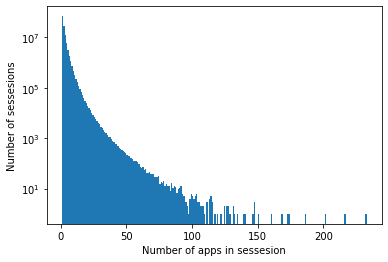

In [28]:
plt.hist(data3.groupby(['user_id','session']).size(),bins=range(1,data3.groupby(['user_id','session']).size().max()+1,1))
plt.xlabel('Number of apps in sessesion')
plt.ylabel('Number of sessesions')
plt.yscale('log')
#plt.title("Distribution of length of sessions")
plt.show()

In [27]:
print("procent of sessions with length one: ",((data3.groupby(['user_id','session']).size())==1).sum()/data3.groupby(['user_id','session']).size().shape[0]*100)
print("number of sessions: ",data3.groupby(['user_id','session']).size().shape[0])

procent of sessions with length one:  55.12311885828394
number of sessions:  125704179


We see that this is on a similar level as before the merge.

### Filtering out the sessions with only one app.

In [29]:
data4=(data3.groupby(['user_id', 'session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length'})

In [30]:
data4=pd.merge(data3, data4, how='left', on=['user_id','session'])

In [31]:
data4=data4[data4.session_length>1]

In [34]:
data4.to_csv("data_sessions_20s_min_length_1.csv",index=False)

In [32]:
print("procent of sessions with length one: ",((data4.groupby(['user_id','session']).size())==1).sum()/data4.groupby(['user_id','session']).size().shape[0]*100)
print("number of sessions: ",data4.groupby(['user_id','session']).size().shape[0])

procent of sessions with length one:  0.0
number of sessions:  56412115


In [33]:
data4.session_length.describe()

count    1.813232e+08
mean     4.811188e+00
std      4.654000e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      2.330000e+02
Name: session_length, dtype: float64

## Testing
Having prepared the data set, we now apply the VMSP.

In [3]:
data=pd.read_csv("data_sessions_20s_min_length_1.csv")

In [5]:
data

,user_id,package_name,start_time,end_time,app_code,time_spend,sequence_number,sequence_Start_time,sequence_end_time,sleep_time,new_session,session,session_length
0,0,com.facebook.katana,0,441,19968,441,1,0,441,0,False,0,7
1,0,com.android.chrome,441,1012,7649,571,2,441,1012,0,False,0,7
2,0,com.google.android.apps.photos,1012,1032,23916,20,3,1012,1032,0,False,0,7
3,0,com.facebook.katana,1042,1502,19968,460,4,1042,1502,10,False,0,7
4,0,com.whatsapp,1512,1572,53003,60,5,1512,1572,10,False,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181323200,9999,com.sonyericsson.conversations,29206941,29206961,45264,20,14899,29206941,29206961,1811,True,8464,2
181323201,9999,com.facebook.katana,29206961,29207029,19968,68,14900,29206961,29207029,0,False,8464,2
181323202,9999,com.google.android.googlequicksearchbox,29207214,29207244,23949,30,14901,29207214,29207244,185,True,8465,3
181323203,9999,com.android.chrome,29207244,29207284,7649,40,14902,29207244,29207284,0,False,8465,3


In [6]:
input_string=data.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [7]:
input_string.to_csv("input_string_20sec_min_len_2.csv",index=False)

In [2]:
input_string=pd.read_csv("input_string_20sec_min_len_2.csv")

In [3]:
input_string

,app_code
0,19968 -1 7649 -1 23916 -1 19968 -1 53003 -1 23967 -1 53003 -1 -2
1,53003 -1 19968 -1 53003 -1 2340 -1 7649 -1 53003 -1 -2
2,19968 -1 51657 -1 53003 -1 -2
3,19968 -1 23926 -1 19968 -1 45345 -1 23967 -1 -2
4,23967 -1 23916 -1 -2
...,...
56412110,19973 -1 2262 -1 -2
56412111,19973 -1 27441 -1 -2
56412112,19968 -1 50614 -1 19973 -1 -2
56412113,45264 -1 19968 -1 -2


In [4]:
dfAsString = input_string.to_string(header=False, index=False).lstrip()

In [5]:
dfAsString=re.sub(r'\n\s+','\n',dfAsString)

In [6]:
f = open(os.path.join(os.getcwd(), '20sec_sessions_min_len_2.txt'), 'w')
f.write(dfAsString)
f.close()

In [11]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_min_len_2.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_min_len_2_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_20sec_sessions_min_len_2_min_sup_1.csv")

CalledProcessError: Command '['java', '-jar', '/home/s164574/motifs_and_competition_in_app_usage/spmf.jar', 'run', 'VMSP', '/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_min_len_2.txt', '/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_20sec_sessions_min_len_2_min_sup_1.txt', '0.01']' returned non-zero exit status 1.

The called process error does not provide any information about the underlaying issue and the calculation is therefore also performed in the terminal. Here the error are found to be "*java.lang.OutOfMemoryError: Java heap space*".
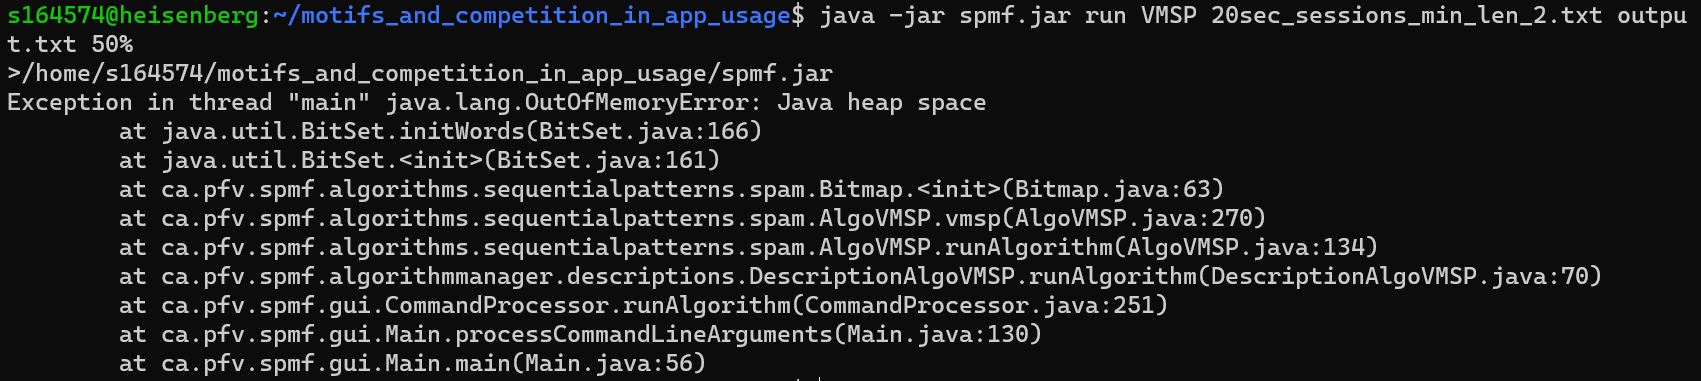

# RUN untill here!!!

### Dealing with infrequent apps
As Here we try to deal with the many infrequent apps in order to make the algortihms work on the the sequences, without experiencing memory propblems, either in terms of garbage collection or in terms of heap memory.

In [3]:
print("Number of different apps occuringing in sequences of more than legnth one: ",data4.app_code.nunique())

Number of different apps occuringing in sequences of more than legnth one:  60013


Now the number of sessions which each of the apps occure in is calculated. This provide sort of an upper limit for high the min. support can be set, and still a pattern of at least length one will be returned.

In [3]:
app_in_n_sessions=data4.groupby(['app_code','user_id']).session.nunique().reset_index().groupby("app_code").session.sum()

In [6]:
app_in_n_sessions.describe()

count    6.001300e+04
mean     2.586290e+03
std      1.414441e+05
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      2.800000e+01
max      2.029606e+07
Name: session, dtype: float64

In [9]:
print("max min support for one app:",app_in_n_sessions.max()/56412115*100)

max min support for one app: 35.97819014585785


In [12]:
print("Number of apps with one procent or more support:",app_in_n_sessions[app_in_n_sessions>=(56412115/100)].shape[0])

Number of apps with one procent or more support: 26


In [83]:
app_in_n_sessions[app_in_n_sessions>=(56412115/100)].index.values

array([ 2259,  7421,  7649,  7653, 18676, 19968, 19973, 23906, 23909,
       23947, 23949, 23967, 27441, 33357, 36529, 44880, 45246, 45260,
       45261, 45264, 45284, 45329, 45846, 50519, 53003, 53996])

In [21]:
print(data4[(data4.app_code==2259)].package_name.unique()[0])
print(data4[(data4.app_code==7421)].package_name.unique()[0])
print(data4[(data4.app_code==7649)].package_name.unique()[0])
print(data4[(data4.app_code==7653)].package_name.unique()[0])
print(data4[(data4.app_code==18676)].package_name.unique()[0])
print(data4[(data4.app_code==19968)].package_name.unique()[0])
print(data4[(data4.app_code==19973)].package_name.unique()[0])
print(data4[(data4.app_code==23906)].package_name.unique()[0])
print(data4[(data4.app_code==23909)].package_name.unique()[0])
print(data4[(data4.app_code==23947)].package_name.unique()[0])
print(data4[(data4.app_code==23949)].package_name.unique()[0])
print(data4[(data4.app_code==23967)].package_name.unique()[0])
print(data4[(data4.app_code==27441)].package_name.unique()[0])
print(data4[(data4.app_code==33357)].package_name.unique()[0])
print(data4[(data4.app_code==36529)].package_name.unique()[0])
print(data4[(data4.app_code==44880)].package_name.unique()[0])
print(data4[(data4.app_code==45246)].package_name.unique()[0])
print(data4[(data4.app_code==45260)].package_name.unique()[0])
print(data4[(data4.app_code==45261)].package_name.unique()[0])
print(data4[(data4.app_code==45264)].package_name.unique()[0])
print(data4[(data4.app_code==45284)].package_name.unique()[0])
print(data4[(data4.app_code==45329)].package_name.unique()[0])
print(data4[(data4.app_code==45846)].package_name.unique()[0])
print(data4[(data4.app_code==50519)].package_name.unique()[0])
print(data4[(data4.app_code==53003)].package_name.unique()[0])
print(data4[(data4.app_code==53996)].package_name.unique()[0])

bbc.mobile.news.uk
com.amazon.mShop.android.shopping
com.android.chrome
com.android.incallui
com.ebay.mobile
com.facebook.katana
com.facebook.orca
com.google.android.apps.maps
com.google.android.apps.messaging
com.google.android.gm
com.google.android.googlequicksearchbox
com.google.android.youtube
com.instagram.android
com.microsoft.office.outlook
com.nianticlabs.pokemongo
com.snapchat.android
com.sony.nfx.app.sfrc
com.sonyericsson.album
com.sonyericsson.android.socialphonebook
com.sonyericsson.conversations
com.sonyericsson.music
com.sonymobile.email
com.spotify.music
com.twitter.android
com.whatsapp
com.yahoo.mobile.client.android.mail


In [29]:
print("number of apps which only occur in one sequenc:",app_in_n_sessions[app_in_n_sessions==1].shape[0])
print("number of apps which only occur in five sequenc or less:",app_in_n_sessions[app_in_n_sessions<=5].shape[0])#median 
print("number of apps which only occur in 28 sequenc or less:",app_in_n_sessions[app_in_n_sessions<=28].shape[0])#75-quantile

number of apps which only occur in one sequenc: 14756
number of apps which only occur in five sequenc or less: 31148
number of apps which only occur in 28 sequenc or less: 45100


As a start we difine the median of 5 or less as the thresshold for when an app is too infrequent to be relevant. How ever to remove these apps without affecting the sequences, we can only remove sequences of length two, where at least one is 

In [4]:
data4=pd.merge(data4, app_in_n_sessions.reset_index().rename(columns={'session':'number_of_sessions'}), how='left', on=['app_code'])

In [5]:
data4['app_less_than_0_01_sessions']=data4.number_of_sessions<=(56412115/100*0.01)

In [8]:
(data4.groupby(['user_id','session']).app_less_than_0_01_sessions.sum()>0).sum()#<=0.01 procent

5668168

In [61]:
(data4.groupby(['user_id','session']).app_less_than_five_sessions.sum()>0).sum()#<=28

229306

In [71]:
(data4.groupby(['user_id','session']).app_less_than_five_sessions.sum()>0).sum()#<=100

560177

In [74]:
(data4.groupby(['user_id','session']).app_less_than_five_sessions.sum()>0).sum()#<=564(56412115/100*0.001)

1745443

In [76]:
(data4.groupby(['user_id','session']).app_less_than_five_sessions.sum()>0).sum()#<=1%

25388149

In [79]:
(data4.groupby(['user_id','session']).app_less_than_five_sessions.sum()>0).sum()#<=56412115/100*0.01

5668168

- Observations which can be romved because they the length of frequent events in session is only 1.
- Observations which can be removed because they the app is less frequent, and either the last or first observation in a session.

In [6]:
data4=pd.merge(data4,(data4.groupby(['user_id','session']).size()-data4.groupby(['user_id','session']).app_less_than_0_01_sessions.sum()).reset_index().rename(columns={0:'session_length_without_infrequent'}),how='left', on=['user_id','session'])

In [12]:
print("number of observations which can be removed, because removing infrequent apps, mean that there is one or non apps left in session",data4[data4.session_length_without_infrequent<=1].shape[0])

number of observations which can be removed, because removing infrequent apps, mean that there is one or non apps left in session 4926066


In [7]:
data4=data4[data4.session_length_without_infrequent>1]

In [15]:
print("number of sessions: ",data4.groupby(['user_id','session']).size().shape[0])
print("number of apps: ",data4.groupby(['app_code']).size().shape[0])

number of sessions:  54065611
number of apps:  49015


we now take a look at the infrequent apps, which are either first or last in a sequence.

if it is true that the app is infrequent and 

In [8]:
data4['app_more_than_0_01_sessions']=data4.app_less_than_0_01_sessions.apply(lambda l: not l)

In [12]:
data4['group_of_infrequent_apps']=data4.groupby(['user_id','session']).app_more_than_0_01_sessions.cumsum()

Now all apps which are infrequent and is part of the initial sequence of infrequent apps in a session, will belong to group 0. These are therefore removed.

In [13]:
data4=data4[data4.group_of_infrequent_apps!=0]

We can now similarly try to identify infrequent apss at the end of a session

In [14]:
data4=pd.merge(data4,data4.groupby(['user_id','session']).agg({'group_of_infrequent_apps':'max'}).reset_index().rename(columns={'group_of_infrequent_apps':'max_group_of_infrequent_apps'}),how='left', on=['user_id','session'])

In [39]:
data4[(data4.group_of_infrequent_apps==data4.max_group_of_infrequent_apps)&(data4.app_less_than_0_01_sessions)]

,package_name,user_id,start_time,end_time,time_spend,app_code,sequence_number,sequence_Start_time,sequence_end_time,sleep_time,new_session,session,session_length,number_of_sessions,app_less_than_0_01_sessions,session_length_without_infrequent,app_more_than_0_01_sessions,group_of_infrequent_apps,max_group_of_infrequent_apps
38,bg.abv.andro.emailapp,0,49406,49416,10,2340,49,49406,49416,0,False,19,4,2704,True,3,False,3,3
144,bg.abv.andro.emailapp,0,267152,267192,40,2340,182,267152,267192,0,False,85,5,2704,True,4,False,4,4
192,bg.abv.andro.emailapp,0,322031,322056,25,2340,236,322031,322056,14,False,110,4,2704,True,3,False,3,3
209,bg.abv.andro.emailapp,0,342318,342365,47,2340,256,342318,342365,0,False,120,3,2704,True,2,False,2,2
335,com.sirmamobile.prodavalnik,0,734511,734931,420,44393,422,734511,734931,0,False,206,5,97,True,3,False,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175391392,com.kb.Carrom3D,9998,34780733,34781894,1161,29223,9077,34780733,34781894,0,False,5025,3,151,True,2,False,2,2
175392106,com.kb.Carrom3D,9998,37784069,37785150,1081,29223,10011,37784069,37785150,0,False,5537,4,151,True,3,False,3,3
175392282,com.kb.Carrom3D,9998,38661190,38661200,10,29223,10278,38661190,38661200,0,False,5708,5,151,True,3,False,3,3
175396793,air.nn.mobile.app.main,9999,13593307,13593365,58,1312,6287,13593307,13593365,0,False,3715,3,63,True,2,False,2,2


In [15]:
data4=data4[(data4.group_of_infrequent_apps!=data4.max_group_of_infrequent_apps)|(data4.app_more_than_0_01_sessions)]

In [16]:
data4=data4.drop(['group_of_infrequent_apps'],axis=1)

We can now take a look at the updated number of sessions, and different apps.

In [43]:
print("number of sessions: ",data4.groupby(['user_id','session']).size().shape[0])
print("number of apps: ",data4.groupby(['app_code']).size().shape[0])

number of sessions:  54065611
number of apps:  39868


The length of the session are now recalculated, after the infrequent apps have been removed.

In [23]:
176397139-993753-927495==data4.shape[0]

True

In [17]:
data4=pd.merge(data4,(data4.groupby(['user_id','session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','session'])

In [30]:
data4[data4.session_length_updated==1]

,package_name,user_id,start_time,end_time,time_spend,app_code,sequence_number,sequence_Start_time,sequence_end_time,sleep_time,new_session,session,session_length,number_of_sessions,app_less_than_0_01_sessions,session_length_without_infrequent,app_more_than_0_01_sessions,group_of_infrequent_apps,max_group_of_infrequent_apps,session_length_updated


So there is no sessions which can be removed.
In stead we now continue to remove infrequent apps by splitting sequences.

In [34]:
print("Number of remaining infrequent apps:",data4[data4.app_less_than_0_01_sessions].shape[0])

Number of remaining infrequent apps: 2404252


In [18]:
data4['new_session']=(data4.new_session | data4.app_less_than_0_01_sessions)

In [19]:
data4['updated_session']=data4.groupby(['user_id']).agg({'new_session':'cumsum'}).astype('int')

again the session length must be recalculated.

In [20]:
data4=data4.drop(['session_length_updated'],axis=1)

In [22]:
data4=data4.drop(['app_more_than_0_01_sessions'],axis=1)

In [25]:
data4=data4.drop(['max_group_of_infrequent_apps'],axis=1)

In [27]:
data4=data4.drop(['session_length_without_infrequent'],axis=1)

In [29]:
data4=data4.drop(['session'],axis=1)

In [30]:
data4.columns

Index(['package_name', 'user_id', 'start_time', 'end_time', 'time_spend',
       'app_code', 'sequence_number', 'sequence_Start_time',
       'sequence_end_time', 'sleep_time', 'new_session', 'session_length',
       'number_of_sessions', 'app_less_than_0_01_sessions', 'updated_session'],
      dtype='object')

In [31]:
data4=pd.merge(data4,(data4.groupby(['user_id','updated_session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','updated_session'])

In [32]:
data4=data4[data4.session_length_updated>1]

In [33]:
print("Number of remaining infrequent apps:",data4[data4.app_less_than_0_01_sessions].shape[0])

Number of remaining infrequent apps: 2280885


The remaining infrequent apps can now be directly removed as a new session is started where they occure, and they therfore all are in the begining of a new session

In [48]:
data4=data4[data4.app_less_than_0_01_sessions!=True]

Again a new session length is neccessary to be calculated.

In [50]:
data4=data4.drop(['session_length_updated'],axis=1)

In [51]:
data4=pd.merge(data4,(data4.groupby(['user_id','updated_session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','updated_session'])

In [54]:
data4=data4[data4.session_length_updated>1]

In [56]:
data4=data4.drop(['session_length'],axis=1)

In [57]:
data4.columns

Index(['package_name', 'user_id', 'start_time', 'end_time', 'time_spend',
       'app_code', 'sequence_number', 'sequence_Start_time',
       'sequence_end_time', 'sleep_time', 'new_session', 'number_of_sessions',
       'app_less_than_0_01_sessions', 'updated_session',
       'session_length_updated'],
      dtype='object')

In [ ]:
56412115#number of sessions
60013#number of apps before

In [9]:
apps_with_one_procent_support=app_in_n_sessions[app_in_n_sessions>=(56412115/100)].index.values

In [19]:
apps_with_one_procent_support.size

26

In [22]:
apps_with_one_procent_support

array([ 2259,  7421,  7649,  7653, 18676, 19968, 19973, 23906, 23909,
       23947, 23949, 23967, 27441, 33357, 36529, 44880, 45246, 45260,
       45261, 45264, 45284, 45329, 45846, 50519, 53003, 53996])

In [15]:
data4['one_procent_support']=data4.app_code.apply(lambda l: l in apps_with_one_procent_support)

In [ ]:
data4.groupby(['user_id','session']).one_procent_support.count().sum()

In [21]:
data4.groupby(['user_id','session']).one_procent_support.any().sum()

54294697

In [74]:
20296058/56412115*100

35.97819014585785

In [75]:
56412115/100*1

564121.15

In [61]:
app_in_n_sessions<=56412115

app_code
0         True
1        False
2         True
3         True
4         True
         ...  
67083     True
67084     True
67085     True
67086     True
67087     True
Name: session, Length: 60013, dtype: bool